# Installation

In [ ]:
!pip install transformers datasets evaluate
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 914.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=3762ba5e36b4b3146541ace443b02808fcf3c7cf56e5f5a4e3df5aba64b21894
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# Imports

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import evaluate
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,DataCollatorForTokenClassification,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFRobertaForTokenClassification,TFAutoModelForTokenClassification,)

In [ ]:
BATCH_SIZE=16
NUM_EPOCHS=2

# Data Preparation

In [ ]:
dataset = load_dataset("conll2003")

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
dataset['train'][20]

{'id': '20',
 'tokens': ['Rare',
  'Hendrix',
  'song',
  'draft',
  'sells',
  'for',
  'almost',
  '$',
  '17,000',
  '.'],
 'pos_tags': [22, 22, 21, 21, 42, 15, 30, 3, 11, 7],
 'chunk_tags': [11, 12, 12, 12, 21, 13, 11, 12, 12, 0],
 'ner_tags': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
model_id="roberta-base"
tokenizer=RobertaTokenizerFast.from_pretrained(model_id,add_prefix_space=True)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
'Rare Hendrix song draft sells for almost $ 17,000.'

In [ ]:
inputs = tokenizer(dataset["train"][20]["tokens"], is_split_into_words=True,)
inputs.tokens()

['<s>',
 'ĠRare',
 'ĠHend',
 'rix',
 'Ġsong',
 'Ġdraft',
 'Ġsells',
 'Ġfor',
 'Ġalmost',
 'Ġ$',
 'Ġ17',
 ',',
 '000',
 'Ġ.',
 '</s>']

In [ ]:
print(dataset['train'][20])

{'id': '20', 'tokens': ['Rare', 'Hendrix', 'song', 'draft', 'sells', 'for', 'almost', '$', '17,000', '.'], 'pos_tags': [22, 22, 21, 21, 42, 15, 30, 3, 11, 7], 'chunk_tags': [11, 12, 12, 12, 21, 13, 11, 12, 12, 0], 'ner_tags': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
print(inputs.word_ids())
print(dataset['train'][20]['ner_tags'])

[None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 9, None]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
labels = dataset["train"][20]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[-100, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [ ]:
def tokenizer_function(dataset):
  out=tokenizer(dataset["tokens"],truncation=True,is_split_into_words=True,)
  out['labels']=align_labels_with_tokens(dataset["ner_tags"],out.word_ids())
  return out

In [ ]:
tokenized_dataset=dataset.map(tokenizer_function,remove_columns=['id','tokens','pos_tags','chunk_tags','ner_tags',])

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [ ]:
tokenized_dataset['train'][20]

{'input_ids': [0,
  28751,
  16544,
  15072,
  2214,
  2479,
  7683,
  13,
  818,
  68,
  601,
  6,
  151,
  479,
  2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [ ]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors="tf"
)

In [ ]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
tf_val_dataset = tokenized_dataset["validation"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [ ]:
for i in tf_train_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(16, 41), dtype=int64, numpy=
array([[    0,  9747, 16488,  4125,  8395,     9,  1470,  1474,    69,
         2194,    25,     5,   232,   128,    29,   346,    65,   693,
        11085,  8007,    77,    79, 12544,    69,  1270,    23,     5,
          232, 12731,  8226,    15,   273,   479,     2,     1,     1,
            1,     1,     1,     1,     1],
       [    0,    91,   875,    22,   248,  2552,    22,  2156,    10,
        36059,   173,    11,     5,  1515,  8728,  2079,     8,    10,
         3395, 31511,    22, 20207,   139,  7948,   385,   108, 14944,
          241,  1560,  1610,    22,   479,     2,     1,     1,     1,
            1,     1,     1,     1,     1],
       [    0,   163,  5219,  2156,    10, 24926,  3055,   594,  1242,
         1250,   254,  2047,     7,    28,  8783,  2156,  3203,   542,
          102,  8598,    53,  3117,  1003,    15,    10,  3051,  4757,
          479,     2,     1,     1,     1,     1,     1,     1,     1

# Modeling

## Based on TFRobertaForSequenceClassification

In [ ]:
model=TFRobertaForTokenClassification.from_pretrained(
    model_id,
    num_labels=9,
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForTokenClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_roberta_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 124061961 (473.26 MB)
Trainable params: 124061961 (473.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [ ]:
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch*NUM_EPOCHS)

In [ ]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps,)

In [ ]:
model.compile(optimizer=optimizer,)
    #metrics=["accuracy"])

In [ ]:
history=model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=NUM_EPOCHS,)

Epoch 1/2
878/878 [==============================] - 280s 241ms/step - loss: 0.1486 - val_loss: 0.0553
Epoch 2/2
878/878 [==============================] - 191s 218ms/step - loss: 0.0435 - val_loss: 0.0471


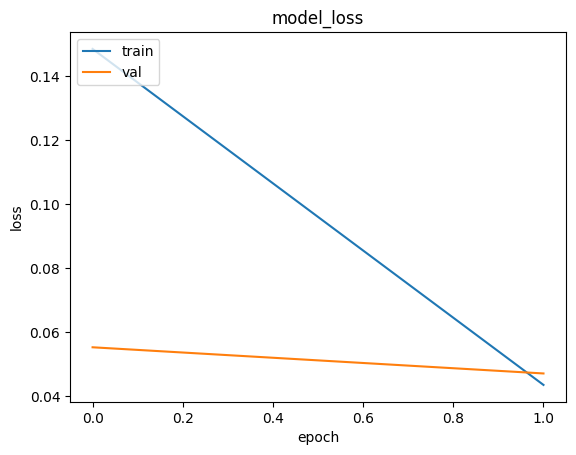

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
metric=evaluate.load("seqeval")

In [ ]:
ind_to_label={0:'O', 1:'B-PER',2:'I-PER',3:'B-ORG',4:'I-ORG',5:'B-LOC',6:'I-LOC',7:'B-MISC',8:'I-MISC'}
all_predictions = []
all_labels = []

In [ ]:
for batch in tf_val_dataset:
  logits = model.predict(batch)["logits"]
  labels = batch["labels"].numpy()
  predictions = tf.argmax(logits, axis=-1).numpy()
  #print(labels)
  #print(predictions)
  for prediction, label in zip(predictions, labels):
    for predicted_idx, label_idx in zip(prediction, label):
      if label_idx == -100:
          continue
      all_predictions.append(ind_to_label[predicted_idx])
      all_labels.append(ind_to_label[label_idx])

1/1 [==============================] - 0s 52ms/step


In [ ]:
print(all_predictions)
print(all_labels)

['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 

In [ ]:
metric.compute(predictions=[all_predictions], references=[all_labels])

{'LOC': {'precision': 0.9689711486118672,
  'recall': 0.9689711486118672,
  'f1': 0.9689711486118672,
  'number': 1837},
 'MISC': {'precision': 0.842479674796748,
  'recall': 0.8991323210412148,
  'f1': 0.8698845750262331,
  'number': 922},
 'ORG': {'precision': 0.9056603773584906,
  'recall': 0.930648769574944,
  'f1': 0.9179845531445384,
  'number': 1341},
 'PER': {'precision': 0.9705251875669882,
  'recall': 0.9831704668838219,
  'f1': 0.97680690399137,
  'number': 1842},
 'overall_precision': 0.9345424567188788,
 'overall_recall': 0.9538875799394143,
 'overall_f1': 0.9441159323727826,
 'overall_accuracy': 0.9879721395477279}

# Testing


In [ ]:
inputs=tokenizer(["Wake Up JoeMarshal, you just got a call from UNESCO for a trip to India"], padding=True,return_tensors="tf")

In [ ]:
print(inputs.tokens())
print(inputs.word_ids())
print(inputs['input_ids'])

['<s>', 'ĠWake', 'ĠUp', 'ĠJoe', 'Marsh', 'al', ',', 'Ġyou', 'Ġjust', 'Ġgot', 'Ġa', 'Ġcall', 'Ġfrom', 'ĠUNESCO', 'Ġfor', 'Ġa', 'Ġtrip', 'Ġto', 'ĠIndia', '</s>']
[None, 0, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None]
tf.Tensor(
[[    0 11601  3105  2101 40825   337     6    47    95   300    10   486
     31 26688    13    10  1805     7   666     2]], shape=(1, 20), dtype=int32)


In [ ]:
logits = model(**inputs).logits
print(logits.shape)
print(tf.argmax(logits,axis=-1))

(1, 20, 9)
tf.Tensor([[0 0 0 1 2 2 0 0 0 0 0 0 0 3 0 0 0 0 5 0]], shape=(1, 20), dtype=int64)


In [ ]:
ind_to_label={0:'O', 1:'B-PER',2:'I-PER',3:'B-ORG',4:'I-ORG',5:'B-LOC',6:'I-LOC',7:'B-MISC',8:'I-MISC'}
out_str=""
current_index=0

In [ ]:
for i in range(1,len(inputs.tokens())-1):
  if tf.argmax(logits,axis=-1)[0][i]!=0:
    out_str+=" "+str(inputs.tokens()[i])+"--->"+str(ind_to_label[tf.argmax(logits,axis=-1).numpy()[0][i]])
  else:
    out_str+=" "+str(inputs.tokens()[i])

In [ ]:
print(out_str.replace("Ġ",""))

 Wake Up Joe--->B-PER Marsh--->I-PER al--->I-PER , you just got a call from UNESCO--->B-ORG for a trip to India--->B-LOC
